<h4>Internal NN implementation<h4>

2
2
['C0', 'C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1', 'C1']


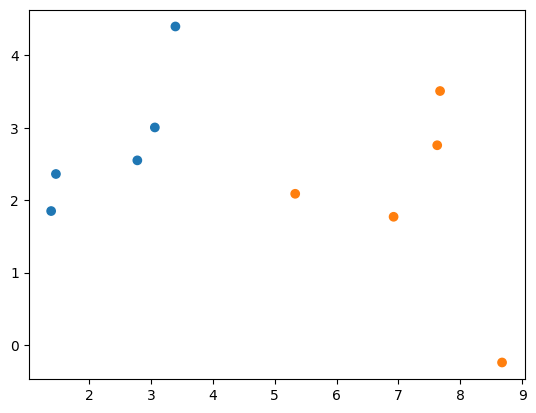

In [32]:
from math import exp
from random import seed
from random import random
import matplotlib.pyplot as plt

# Test training backprop algorithm
seed(1)
dataset = [[2.7810836, 2.550537003, 0],
	[1.465489372, 2.362125076, 0],
	[3.396561688, 4.400293529, 0],
	[1.38807019, 1.850220317, 0],
	[3.06407232, 3.005305973, 0],
	[7.627531214, 2.759262235, 1],
	[5.332441248, 2.088626775, 1],
	[6.922596716, 1.77106367, 1],
	[8.675418651, -0.242068655, 1],
	[7.673756466, 3.508563011, 1]]

n_inputs = len(dataset[0]) - 1
print(n_inputs)
s = set([row[-1] for row in dataset])
n_outputs = len(s)
print(n_outputs)

import numpy as np
ds = np.array(dataset)
labels = ['C0' if x == 0 else 'C1' for x in ds[:,-1]]
print(labels)
plt.scatter(ds[:, 0], ds[:, 1], c=labels) # https://matplotlib.org/stable/tutorials/colors/colors.html
plt.show()

In [33]:
# Initialize a network. Y = X * W + b
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()

	hidden_layer = []
	for i in range(n_hidden):
		weights_b = {'weights':[random() for i in range(n_inputs + 1)]}	# W * x + B
		hidden_layer.append(weights_b)
	print(f'input-hidden={hidden_layer}')

	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	print(f'hidden-output={output_layer}')

	network.append(output_layer)
	return network

print('input unit=', n_inputs, 'hidden unit=', 2, 'output unit=', n_outputs)
network = initialize_network(n_inputs, 2, n_outputs)

input unit= 2 hidden unit= 2 output unit= 2
input-hidden=[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}, {'weights': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381]}]
hidden-output=[{'weights': [0.651592972722763, 0.7887233511355132, 0.0938595867742349]}, {'weights': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337]}]


<h3>activation</h3><img src='./fig/activation.jpg'/><br/><img src='https://journaldev.nyc3.digitaloceanspaces.com/2020/12/formula.png'/>

In [34]:
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]					# b
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]	# W * X
	return activation

# Transfer neuron activation. sigmoidal activation function
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))


In [35]:
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs


<img src='.\fig\dev_sig.jpg'/>

In [36]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):	# back > front layer
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):		# 3. back propagation
				error = 0.0
				for neuron in network[i + 1]:	# chain rule. network[i].error <= network[i + 1].delta
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):		# 1. calc error of back layer
				neuron = layer[j]
				errors.append(neuron['output'] - expected[j])	# error
				
		for j in range(len(layer)):			# 2. calc delta w, b
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])	# delta = loss * dw



In [37]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]	# input row[x1, x2, label]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):	# update weights. wiehgts - lr * delta * input
				neuron['weights'][j] -= l_rate * neuron['delta'] * inputs[j]	# back propagatinon. W * input
			neuron['weights'][-1] -= l_rate * neuron['delta']					# back propagatinon. B



In [38]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		sum_error = 0
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]		# one hot encode conversion.
			expected[row[-1]] = 1							# assign ground true
			sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])	# Sum Squared Error
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)
		print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))



In [39]:
# Test training backprop algorithm
seed(1)
dataset = [[2.7810836, 2.550537003,0],
	[1.465489372, 2.362125076,0],
	[3.396561688, 4.400293529,0],
	[1.38807019, 1.850220317,0],
	[3.06407232, 3.005305973,0],
	[7.627531214, 2.759262235,1],
	[5.332441248, 2.088626775,1],
	[6.922596716, 1.77106367,1],
	[8.675418651, -0.242068655,1],
	[7.673756466, 3.508563011,1]]
n_inputs = len(dataset[0]) - 1
n_outputs = len(set([row[-1] for row in dataset]))

network = initialize_network(n_inputs, 2, n_outputs)
train_network(network, dataset, 0.5, 20, n_outputs)


input-hidden=[{'weights': [0.13436424411240122, 0.8474337369372327, 0.763774618976614]}, {'weights': [0.2550690257394217, 0.49543508709194095, 0.4494910647887381]}]
hidden-output=[{'weights': [0.651592972722763, 0.7887233511355132, 0.0938595867742349]}, {'weights': [0.02834747652200631, 0.8357651039198697, 0.43276706790505337]}]
>epoch=0, lrate=0.500, error=6.350
>epoch=1, lrate=0.500, error=5.531
>epoch=2, lrate=0.500, error=5.221
>epoch=3, lrate=0.500, error=4.951
>epoch=4, lrate=0.500, error=4.519
>epoch=5, lrate=0.500, error=4.173
>epoch=6, lrate=0.500, error=3.835
>epoch=7, lrate=0.500, error=3.506
>epoch=8, lrate=0.500, error=3.192
>epoch=9, lrate=0.500, error=2.898
>epoch=10, lrate=0.500, error=2.626
>epoch=11, lrate=0.500, error=2.377
>epoch=12, lrate=0.500, error=2.153
>epoch=13, lrate=0.500, error=1.953
>epoch=14, lrate=0.500, error=1.774
>epoch=15, lrate=0.500, error=1.614
>epoch=16, lrate=0.500, error=1.472
>epoch=17, lrate=0.500, error=1.346
>epoch=18, lrate=0.500, error=1

In [40]:
for layer in network:
	print(layer)

[{'weights': [-1.4688375095432327, 1.850887325439514, 1.0858178629550297], 'output': 0.029980305604426185, 'delta': 0.0059546604162323625}, {'weights': [0.37711098142462157, -0.0625909894552989, 0.2765123702642716], 'output': 0.9456229000211323, 'delta': -0.0026279652850863837}]
[{'weights': [2.515394649397849, -0.3391927502445985, -0.9671565426390275], 'output': 0.23648794202357587, 'delta': 0.04270059278364587}, {'weights': [-2.5584149848484263, 1.0036422106209202, 0.42383086467582715], 'output': 0.7790535202438367, 'delta': -0.03803132596437354}]
